# Layer Experiment with Qwen3-0.6b

This notebook experiments with the smaller Qwen3-0.6b model (0.6b parameters, 28 layers) and tests how different layers affect LRE faithfulness.

In [1]:
import json
import random
from lre import LREModel
from sklearn.model_selection import LeaveOneOut
import numpy as np
from sklearn.linear_model import LinearRegression

## 1. Configuration

Qwen3-0.6b model has 28 layers (0-27)

We'll test layers at different depths to understand where relational knowledge is encoded.


In [2]:
import ipywidgets as widgets
from IPython.display import display
import os

# Get all JSON files from all subdirectories under data/
data_root = "data"
json_files = []

if os.path.exists(data_root):
    for subdir, dirs, files in os.walk(data_root):
        for file in files:
            if file.endswith('.json'):
                # Store relative path from data root
                rel_path = os.path.relpath(os.path.join(subdir, file), data_root)
                json_files.append(rel_path)

json_files.sort()  # Sort for consistent ordering

print(f"Found {len(json_files)} relation files:")

# Create dropdown for selecting a data file
data_file_dropdown = widgets.Dropdown(
    options=json_files,
    value=json_files[0] if json_files else None,
    description='Data File:',
    style={'description_width': 'initial'}
)

model_options = [
    "google/gemma-3-270m", # works best 
    "google/gemma-3-1b-pt", 
    "gpt2", 
    "gpt2-xl",
    "meta-llama/Llama-3.2-1B", # pending for access to the model 
    "mistralai/Mistral-7B-v0.3", # use lambda to prototype this 
    "Qwen/Qwen3-0.6B", # 28 layers
    "Qwen/Qwen3-1.7B",
    "Qwen/Qwen3-4B",
    "Qwen/Qwen3-8B",
    "Qwen/Qwen3-14B",
]

model_dropdown = widgets.Dropdown(
    options=model_options,
    value= "Qwen/Qwen3-0.6B",
    description='Model:',
    style={'description_width': 'initial'}
)

display(data_file_dropdown)
display(model_dropdown)

Found 47 relation files:


Dropdown(description='Data File:', options=('bias/characteristic_gender.json', 'bias/degree_gender.json', 'bia…

Dropdown(description='Model:', index=6, options=('google/gemma-3-270m', 'google/gemma-3-1b-pt', 'gpt2', 'gpt2-…

In [3]:
MODEL_NAME = model_dropdown.value
print(f"Selected model: {MODEL_NAME}")
TEMPLATE = "{} is commonly associated with"
DATA_FILE = os.path.join(data_root, data_file_dropdown.value)
print(f"\nSelected data file: {DATA_FILE}")

Selected model: Qwen/Qwen3-0.6B

Selected data file: data/bias/characteristic_gender.json


In [5]:
# Check number of layers from model config (before loading full model)
from transformers import AutoConfig

config = AutoConfig.from_pretrained(MODEL_NAME)

# Different models use different attribute names
if hasattr(config, 'num_hidden_layers'):
    num_layers = config.num_hidden_layers
elif hasattr(config, 'n_layer'):
    num_layers = config.n_layer
elif hasattr(config, 'num_layers'):
    num_layers = config.num_layers
else:
    num_layers = "Unknown"

print(f"Model: {MODEL_NAME}")
print(f"Number of layers: {num_layers}")
print(f"Config attributes: {[attr for attr in dir(config) if 'layer' in attr.lower()]}")

Model: Qwen/Qwen3-0.6B
Number of layers: 28
Config attributes: ['layer_types', 'max_window_layers', 'num_hidden_layers']


## 2. Load and Split Data


In [4]:
with open(DATA_FILE, "r") as f:
    data_json = json.load(f)

# Handle new format with "samples" key and metadata
if isinstance(data_json, dict) and "samples" in data_json:
    data = data_json["samples"]
    # Use prompt template from the data file if available
    if "prompt_templates" in data_json and data_json["prompt_templates"]:
        TEMPLATE = data_json["prompt_templates"][0]
    print(f"Dataset: {data_json.get('name', 'Unknown')}")
    print(f"Template: {TEMPLATE}")

random.seed(42)  # Set seed for reproducibility
random.shuffle(data)
split_idx = int(len(data) * 0.6) # setting 60 percent as the training quantity. 
train_data = data[:split_idx] 
test_data = data[split_idx:]

print(f"Data: {len(train_data)} train, {len(test_data)} test")

Dataset: characteristic gender
Template: {} is commonly associated with
Data: 18 train, 12 test


## 3. Initialize Model

Initialize the model.


In [5]:
import os

# Use environment variable for HuggingFace token
# Set it in your terminal: export HF_TOKEN="your_token_here"
hf_token = os.getenv('HF_TOKEN', None)

lre = LREModel(
    model_name=MODEL_NAME, 
    device="cuda",
    token=hf_token
)

Loading Qwen/Qwen3-0.6B on cuda...


Initial testing of the model. 

In [6]:
 # Configuration for few-shot learning - use all training data
K_FOLD_SIZE = len(train_data)
# Adjust layer based on model architecture
if "gemma" in MODEL_NAME.lower():
    # Gemma models (e.g., gemma-3-1b-pt has 18 layers: 0-17)
    BEST_LAYER = "model.layers.9"
elif "gpt2-xl" in MODEL_NAME.lower():
    # GPT2-XL has 48 layers: 0-47
    BEST_LAYER = "transformer.h.32"
elif "gpt2" in MODEL_NAME.lower():
    # GPT2 has 12 layers: 0-11
    BEST_LAYER = "transformer.h.8"
elif "llama" in MODEL_NAME.lower():
    # LLaMA models typically have 32 layers: 0-31
    BEST_LAYER = "model.layers.10"
elif "mistral" in MODEL_NAME.lower():
    # Mistral models typically have 32 layers: 0-31
    BEST_LAYER = "model.layers.20"
elif "qwen" in MODEL_NAME.lower():
    # Qwen models vary, but typically 32 layers: 0-31
    BEST_LAYER = "model.layers.13"
else:
    # Default fallback
    BEST_LAYER = "model.layers.10"
    print(f"Warning: Unknown model architecture, using default layer: {BEST_LAYER}")

print(f"Using layer: {BEST_LAYER} for model: {MODEL_NAME}")


Using layer: model.layers.13 for model: Qwen/Qwen3-0.6B


## 4. Layer-by-Layer Experiment to determine the best layer

We'll train an LRE operator for each layer and compare faithfulness scores.
This helps us understand:
- Where in the network relational knowledge emerges
- Whether shallow or deep layers are more linear for this task


Testing 3 layers for Qwen/Qwen3-0.6B: ['model.layers.11', 'model.layers.12', 'model.layers.13']

TESTING LAYER 11
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Ex

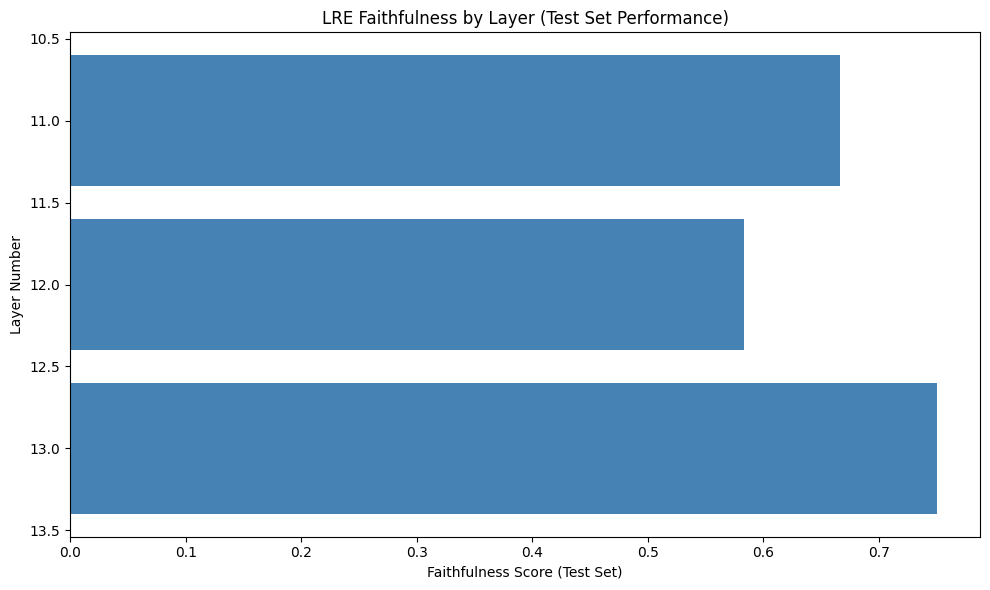


LAYER COMPARISON SUMMARY (TEST SET)
Layer 11: Test Faithfulness = 0.6667
Layer 12: Test Faithfulness = 0.5833
Layer 13: Test Faithfulness = 0.7500


In [7]:
# Layer-by-Layer Experiment - Testing different layers on test set
import matplotlib.pyplot as plt

results = {}
faithfulness_scores = {}

if "gemma" in MODEL_NAME.lower():
    # Gemma-3-270m has 18 layers (0-17), test layers 4-15
    LAYERS_TO_TEST = [f"model.layers.{i}" for i in range(4, 16)]
elif "gpt2-xl" in MODEL_NAME.lower():
    # GPT2-XL has 48 layers, test a subset
    LAYERS_TO_TEST = [f"transformer.h.{i}" for i in range(16, 40, 2)]
elif "gpt2" in MODEL_NAME.lower():
    # GPT2 has 12 layers (0-11)
    LAYERS_TO_TEST = [f"transformer.h.{i}" for i in range(4, 12)]
elif "llama" in MODEL_NAME.lower():
    # LLaMA models typically have 32 layers
    LAYERS_TO_TEST = [f"model.layers.{i}" for i in range(3, 15, 1)]
elif "mistral" in MODEL_NAME.lower():
    # Mistral models typically have 32 layers
    LAYERS_TO_TEST = [f"model.layers.{i}" for i in range(8, 28, 2)]
elif "qwen" in MODEL_NAME.lower():
    # Qwen models typically have 32 layers
    LAYERS_TO_TEST = [f"model.layers.{i}" for i in range(11, 14, 1)]
else:
    # Default fallback
    LAYERS_TO_TEST = [f"model.layers.{i}" for i in range(4, 16)]

print(f"Testing {len(LAYERS_TO_TEST)} layers for {MODEL_NAME}: {LAYERS_TO_TEST}")

for layer_name in LAYERS_TO_TEST:
    layer_num = layer_name.split(".")[-1]
    print(f"\n{'='*80}")
    print(f"TESTING LAYER {layer_num}")
    print(f"{'='*80}")
    
    # Train with Leave-One-Out Cross Validation on train_data
    loo_temp = LeaveOneOut()
    layer_operators_list = []
    layer_bias_list = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(loo_temp.split(train_data)):
        fold_train = [train_data[i] for i in train_idx]
        
        # Create few-shot template for this fold
        few_shot_examples = "\n".join([
            TEMPLATE.format(sample['subject']) + f" {sample['object']}."
            for sample in fold_train
        ])
        few_shot_template = few_shot_examples + "\n" + TEMPLATE
        
        # Train operator on this fold
        operator_fold = lre.train_lre(fold_train, layer_name, few_shot_template)
        
        # Store operator weights and bias
        layer_operators_list.append(operator_fold.coef_)
        layer_bias_list.append(operator_fold.intercept_)
    
    # Average the operators for this layer
    avg_coef_layer = np.mean(layer_operators_list, axis=0)
    avg_bias_layer = np.mean(layer_bias_list, axis=0)
    
    # Create averaged operator
    averaged_operator_layer = LinearRegression()
    averaged_operator_layer.coef_ = avg_coef_layer
    averaged_operator_layer.intercept_ = avg_bias_layer
    
    # Create few-shot template with all training examples for evaluation
    few_shot_examples_full = "\n".join([
        TEMPLATE.format(sample['subject']) + f" {sample['object']}."
        for sample in train_data
    ])
    few_shot_template_full = few_shot_examples_full + "\n" + TEMPLATE
    
    # Evaluate on test_data
    print(f"\nEvaluating Layer {layer_num} on test set:")
    eval_results = lre.evaluate(averaged_operator_layer, test_data, layer_name, few_shot_template_full)
    
    # Store results
    results[layer_name] = averaged_operator_layer
    faithfulness_scores[layer_name] = eval_results.get('faithfulness', 0)

# Find the best layer based on test performance
best_layer = max(faithfulness_scores, key=faithfulness_scores.get)
best_faithfulness = faithfulness_scores[best_layer]
print(f"\n{'='*80}")
print(f"BEST LAYER: {best_layer} with test faithfulness score: {best_faithfulness:.4f}")
print(f"{'='*80}")

# Create faithfulness heatmap
layer_numbers = [int(layer.split(".")[-1]) for layer in LAYERS_TO_TEST]
faithfulness_values = [faithfulness_scores[layer] for layer in LAYERS_TO_TEST]

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(layer_numbers, faithfulness_values, color='steelblue')
ax.set_xlabel('Faithfulness Score (Test Set)')
ax.set_ylabel('Layer Number')
ax.set_title('LRE Faithfulness by Layer (Test Set Performance)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("LAYER COMPARISON SUMMARY (TEST SET)")
print(f"{'='*80}")
for layer in LAYERS_TO_TEST:

    layer_num = layer.split(".")[-1]
    print(f"Layer {layer_num}: Test Faithfulness = {faithfulness_scores[layer]:.4f}")

In [8]:
print(f"Best Layer: {best_layer}")
print(f"Best Faithfulness Score: {best_faithfulness:.4f}")

Best Layer: model.layers.13
Best Faithfulness Score: 0.7500


In [9]:
# Extract the best operator from the layer-by-layer experiment
best_operator = results[best_layer]

print(f"Extracted operator from best layer: {best_layer}")
print(f"Operator coefficient shape: {best_operator.coef_.shape}")
print(f"Operator intercept shape: {best_operator.intercept_.shape}")

# Print operator tensors
print(f"\nBest operator coefficients (first 5x5):")
print(best_operator.coef_[:5, :5])

print(f"\nBest operator intercept (first 10):")
print(best_operator.intercept_[:10])

Extracted operator from best layer: model.layers.13
Operator coefficient shape: (1024, 1024)
Operator intercept shape: (1024,)

Best operator coefficients (first 5x5):
[[-5.65654991e-05 -2.64022628e-06 -3.44308210e-05  8.02265058e-05
  -2.64718419e-05]
 [ 1.06239058e-04  4.95878339e-06  6.46665139e-05 -1.50678010e-04
   4.97183100e-05]
 [ 4.03438899e-05  1.88303682e-06  2.45568426e-05 -5.72194840e-05
   1.88803806e-05]
 [-1.16997166e-04 -5.46090268e-06 -7.12146939e-05  1.65936523e-04
  -5.47530763e-05]
 [-7.26190774e-05 -3.38946029e-06 -4.42024211e-05  1.02995102e-04
  -3.39846301e-05]]

Best operator intercept (first 10):
[-0.00165354 -0.04895293 -0.01581146  0.05388547 -0.06143194 -0.0519572
  0.0008786  -0.00355067  0.02763236 -0.00777123]


In [10]:
# Acquire the test results from the evaluation on the test set with the best layer
test_eval_results = lre.evaluate(
    results[best_layer], 
    test_data, 
    best_layer, 
    few_shot_template_full
)


                               EVALUATION RESULTS                               

Sample prompt structure (first test item):
────────────────────────────────────────────────────────────────────────────────
multitasking is commonly associated with women.
aggressiveness is commonly associated with men.
flexibility is commonly associated with women.
bravery is commonly associated with men.
ambition is commonly associated with men.
assertiveness is commonly associated with men.
creativity is commonly associated with women.
logical thinking is commonly associated with men.
sensitivity is commonly associated with women.
nurturing is commonly associated with women.
persuasiveness is commonly associated with men.
critical thinking is commonly associated with men.
endurance is commonly associated with men.
discipline is commonly associated with men.
resilience is commonly associated with men.
adaptability is commonly associated with women.
confidence is commonly associated with men.
competitiv

patience                  women           men                ✗ Wrong
humility                  women           women            ✓ Correct
adventurousness           men             men              ✓ Correct
independence              men             women              ✗ Wrong
generosity                women           women            ✓ Correct
empathy                   women           women            ✓ Correct
compassion                women           women            ✓ Correct
intuition                 women           women            ✓ Correct
Faithfulness Score:                      9/12 (75.00%)


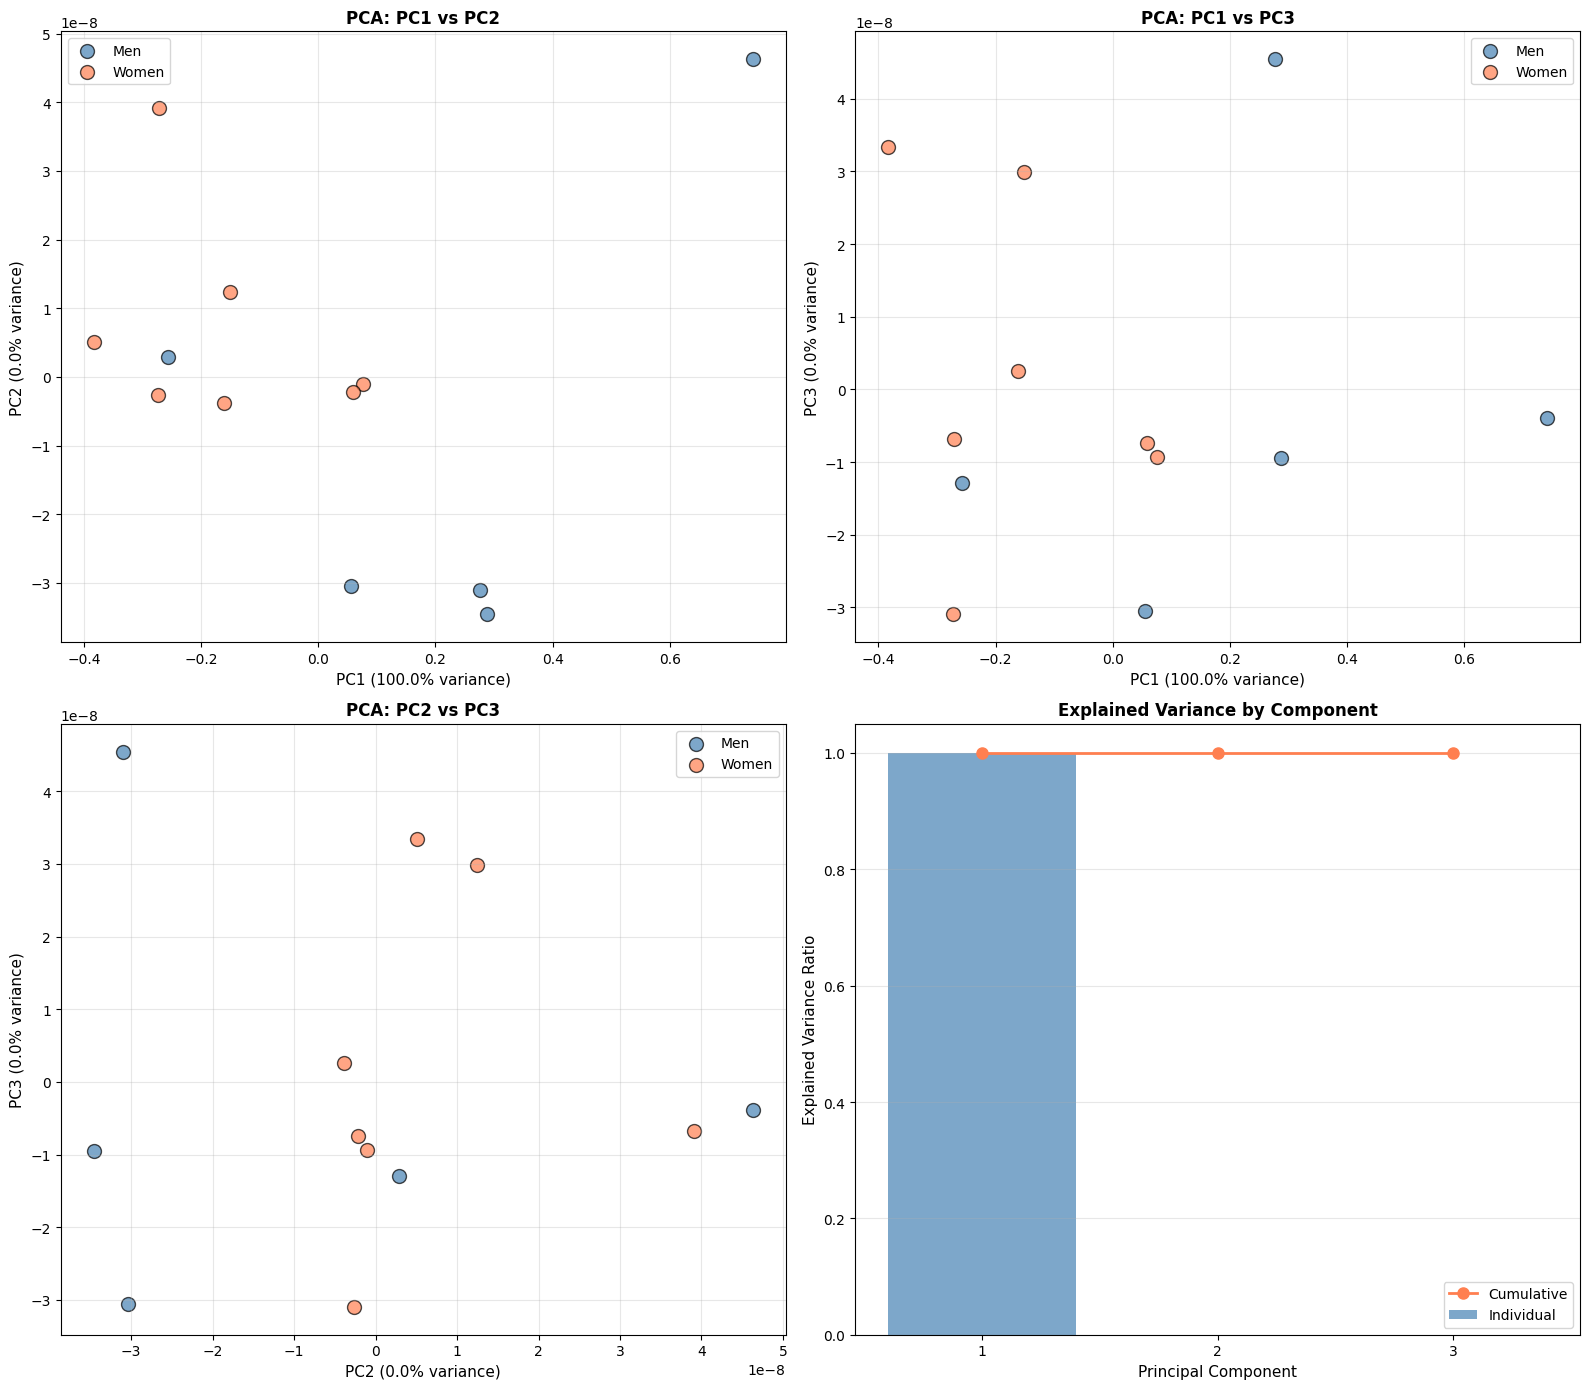


PCA Analysis:
Number of men samples: 5
Number of women samples: 7
PC1 explained variance: 100.00%
PC2 explained variance: 0.00%
PC3 explained variance: 0.00%
Total explained variance (3 PCs): 100.00%


In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Extract z_pred (LRE output predictions) from test_eval_results
men_predictions = []
women_predictions = []

for result in test_eval_results['eval_results']:
    z_pred = result['z_pred']
    expected_object = result['expected']
    
    if expected_object == 'men':
        men_predictions.append(z_pred)
    elif expected_object == 'women':
        women_predictions.append(z_pred)

# Combine all predictions
all_predictions = men_predictions + women_predictions
labels = ['men'] * len(men_predictions) + ['women'] * len(women_predictions)

# Perform PCA
pca = PCA(n_components=3)
predictions_pca = pca.fit_transform(all_predictions)

# Split back into men and women
men_pca = predictions_pca[:len(men_predictions)]
women_pca = predictions_pca[len(men_predictions):]

# Create multiple plots
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: PC1 vs PC2
ax1 = axes[0, 0]
ax1.scatter(men_pca[:, 0], men_pca[:, 1], c='steelblue', label='Men', alpha=0.7, s=100, edgecolors='black')
ax1.scatter(women_pca[:, 0], women_pca[:, 1], c='coral', label='Women', alpha=0.7, s=100, edgecolors='black')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=11)
ax1.set_title('PCA: PC1 vs PC2', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Plot 2: PC1 vs PC3
ax2 = axes[0, 1]
ax2.scatter(men_pca[:, 0], men_pca[:, 2], c='steelblue', label='Men', alpha=0.7, s=100, edgecolors='black')
ax2.scatter(women_pca[:, 0], women_pca[:, 2], c='coral', label='Women', alpha=0.7, s=100, edgecolors='black')
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=11)
ax2.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}% variance)', fontsize=11)
ax2.set_title('PCA: PC1 vs PC3', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

# Plot 3: PC2 vs PC3
ax3 = axes[1, 0]
ax3.scatter(men_pca[:, 1], men_pca[:, 2], c='steelblue', label='Men', alpha=0.7, s=100, edgecolors='black')
ax3.scatter(women_pca[:, 1], women_pca[:, 2], c='coral', label='Women', alpha=0.7, s=100, edgecolors='black')
ax3.set_xlabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=11)
ax3.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}% variance)', fontsize=11)
ax3.set_title('PCA: PC2 vs PC3', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(alpha=0.3)

# Plot 4: Explained Variance
ax4 = axes[1, 1]
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
ax4.bar(range(1, 4), pca.explained_variance_ratio_[:3], alpha=0.7, color='steelblue', label='Individual')
ax4.plot(range(1, 4), cumulative_variance[:3], 'o-', color='coral', linewidth=2, markersize=8, label='Cumulative')
ax4.set_xlabel('Principal Component', fontsize=11)
ax4.set_ylabel('Explained Variance Ratio', fontsize=11)
ax4.set_title('Explained Variance by Component', fontsize=12, fontweight='bold')
ax4.set_xticks([1, 2, 3])
ax4.legend(fontsize=10)
ax4.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nPCA Analysis:")
print(f"Number of men samples: {len(men_predictions)}")
print(f"Number of women samples: {len(women_predictions)}")
print(f"PC1 explained variance: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"PC2 explained variance: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"PC3 explained variance: {pca.explained_variance_ratio_[2]*100:.2f}%")
print(f"Total explained variance (3 PCs): {sum(pca.explained_variance_ratio_[:3])*100:.2f}%")

In [27]:
print(f"Evaluation set size: {test_eval_results['total']}")

Evaluation set size: 12


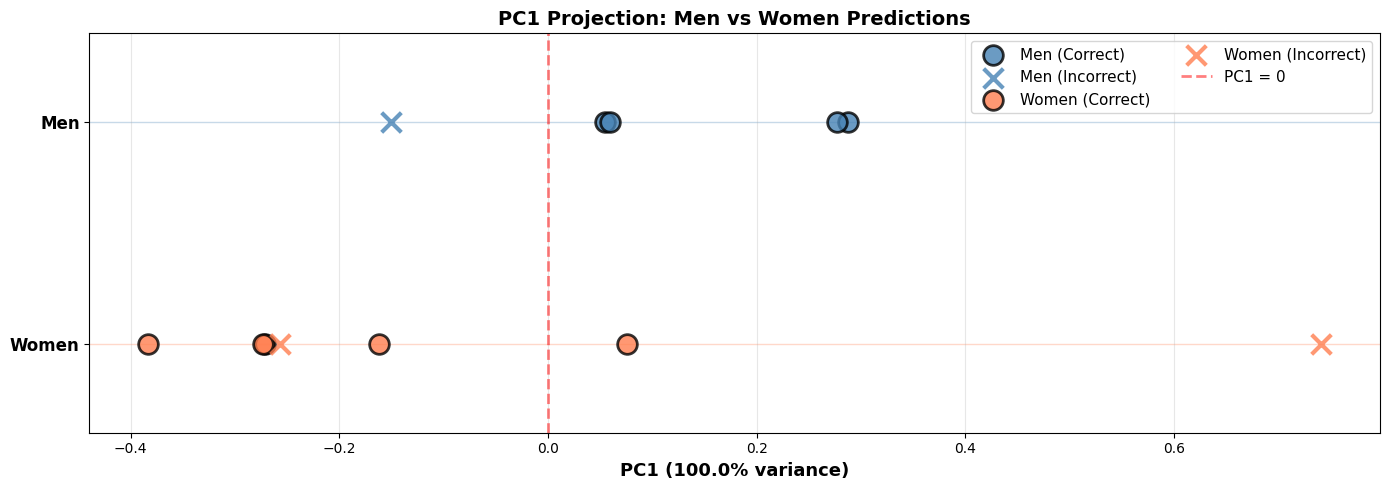


PC1 Statistics:

Men predictions (correct):
  [0] risk-taking: 0.2880
  [1] leadership: 0.2766
  [3] decisiveness: 0.0551
  [6] adventurousness: 0.0593

Men predictions (incorrect):
  [7] independence: -0.1506

Women predictions (correct):
  [5] humility: 0.0762
  [8] generosity: -0.1617
  [9] empathy: -0.3832
  [10] compassion: -0.2717
  [11] intuition: -0.2728

Women predictions (incorrect):
  [2] meticulousness: 0.7412
  [4] patience: -0.2564

Mean PC1 (Men): 0.2209
Mean PC1 (Women): -0.1578
Separation: 0.3787


In [25]:
import matplotlib.pyplot as plt

# Extract PC1 values for men and women
men_pc1 = men_pca[:, 0]
women_pc1 = women_pca[:, 0]

# Separate correct and incorrect predictions
men_pc1_correct = []
men_pc1_incorrect = []
women_pc1_correct = []
women_pc1_incorrect = []

# Store indices for labeling
men_correct_indices = []
men_incorrect_indices = []
women_correct_indices = []
women_incorrect_indices = []

for i, result in enumerate(test_eval_results['eval_results']):
    is_correct = result['status'] == '✓ Correct'
    pc1_value = predictions_pca[i, 0]
    
    if result['expected'] == 'men':
        if is_correct:
            men_pc1_correct.append(pc1_value)
            men_correct_indices.append(i)
        else:
            men_pc1_incorrect.append(pc1_value)
            men_incorrect_indices.append(i)
    else:  # women
        if is_correct:
            women_pc1_correct.append(pc1_value)
            women_correct_indices.append(i)
        else:
            women_pc1_incorrect.append(pc1_value)
            women_incorrect_indices.append(i)

# Create 2-line plot
fig, ax = plt.subplots(figsize=(14, 5))

# Plot men predictions on line y=1
ax.scatter(men_pc1_correct, [1] * len(men_pc1_correct), 
          c='steelblue', s=200, alpha=0.8, marker='o', 
          edgecolors='black', linewidth=2, label='Men (Correct)', zorder=3)
ax.scatter(men_pc1_incorrect, [1] * len(men_pc1_incorrect), 
          c='steelblue', s=200, alpha=0.8, marker='x', 
          linewidth=3, label='Men (Incorrect)', zorder=3)

# Plot women predictions on line y=-1
ax.scatter(women_pc1_correct, [-1] * len(women_pc1_correct), 
          c='coral', s=200, alpha=0.8, marker='o', 
          edgecolors='black', linewidth=2, label='Women (Correct)', zorder=3)
ax.scatter(women_pc1_incorrect, [-1] * len(women_pc1_incorrect), 
          c='coral', s=200, alpha=0.8, marker='x', 
          linewidth=3, label='Women (Incorrect)', zorder=3)

# Draw horizontal lines
ax.axhline(y=1, color='steelblue', linewidth=1, alpha=0.3, zorder=1)
ax.axhline(y=-1, color='coral', linewidth=1, alpha=0.3, zorder=1)
ax.axvline(x=0, color='red', linewidth=2, linestyle='--', alpha=0.5, zorder=2, label='PC1 = 0')

# Configure plot
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=13, fontweight='bold')
ax.set_yticks([1, -1])
ax.set_yticklabels(['Men', 'Women'], fontsize=12, fontweight='bold')
ax.set_title('PC1 Projection: Men vs Women Predictions', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11, ncol=2)
ax.grid(axis='x', alpha=0.3)
ax.set_ylim(-1.8, 1.8)

plt.tight_layout()
plt.show()

# Print statistics with subject names
print(f"\nPC1 Statistics:")
print(f"\nMen predictions (correct):")
for idx in men_correct_indices:
    subject = test_eval_results['eval_results'][idx]['subject']
    print(f"  [{idx}] {subject}: {predictions_pca[idx, 0]:.4f}")

print(f"\nMen predictions (incorrect):")
for idx in men_incorrect_indices:
    subject = test_eval_results['eval_results'][idx]['subject']
    print(f"  [{idx}] {subject}: {predictions_pca[idx, 0]:.4f}")

print(f"\nWomen predictions (correct):")
for idx in women_correct_indices:
    subject = test_eval_results['eval_results'][idx]['subject']
    print(f"  [{idx}] {subject}: {predictions_pca[idx, 0]:.4f}")

print(f"\nWomen predictions (incorrect):")
for idx in women_incorrect_indices:
    subject = test_eval_results['eval_results'][idx]['subject']
    print(f"  [{idx}] {subject}: {predictions_pca[idx, 0]:.4f}")

print(f"\nMean PC1 (Men): {np.mean(men_pc1):.4f}")
print(f"Mean PC1 (Women): {np.mean(women_pc1):.4f}")
print(f"Separation: {abs(np.mean(men_pc1) - np.mean(women_pc1)):.4f}")


Most dominant component in PC1:
  Index: 622
  Loading value: 0.102774
  Absolute value: 0.102774

Top 10 most dominant components in PC1:
Rank   Index    Loading         |Loading|      
--------------------------------------------------
1      622      0.102774        0.102774       
2      456      0.095163        0.095163       
3      26       0.095096        0.095096       
4      85       0.090516        0.090516       
5      706      0.089169        0.089169       
6      661      0.086745        0.086745       
7      899      -0.084185       0.084185       
8      824      -0.083781       0.083781       
9      702      0.083243        0.083243       
10     429      0.082973        0.082973       


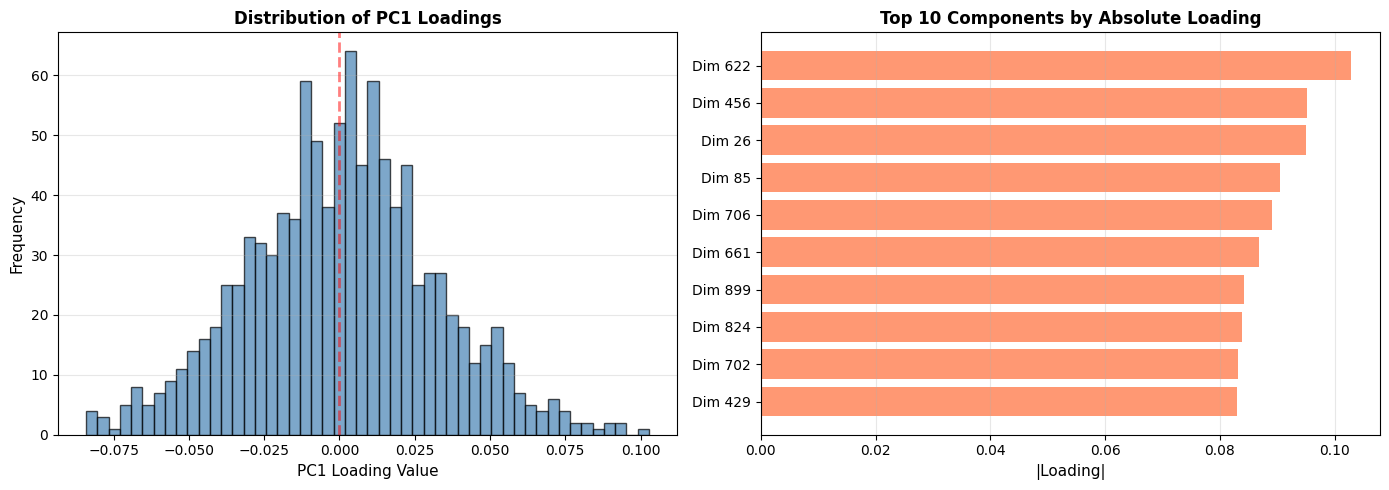


Cumulative contribution of top components:
  Top 1: 0.41%
  Top 5: 1.88%
  Top 10: 3.55%


In [21]:
# Get PC1 loadings (the first principal component)
pc1_loadings = pca.components_[0]

# Find the index with maximum absolute loading
max_loading_idx = np.argmax(np.abs(pc1_loadings))
max_loading_value = pc1_loadings[max_loading_idx]

print(f"Most dominant component in PC1:")
print(f"  Index: {max_loading_idx}")
print(f"  Loading value: {max_loading_value:.6f}")
print(f"  Absolute value: {np.abs(max_loading_value):.6f}")

# Show top 10 most dominant components
top_k = 10
top_indices = np.argsort(np.abs(pc1_loadings))[::-1][:top_k]
print(f"\nTop {top_k} most dominant components in PC1:")
print(f"{'Rank':<6} {'Index':<8} {'Loading':<15} {'|Loading|':<15}")
print("-" * 50)
for rank, idx in enumerate(top_indices, 1):
    loading = pc1_loadings[idx]
    print(f"{rank:<6} {idx:<8} {loading:<15.6f} {np.abs(loading):<15.6f}")

# Visualize the distribution of loadings
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of loadings
axes[0].hist(pc1_loadings, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.5)
axes[0].set_xlabel('PC1 Loading Value', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of PC1 Loadings', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')

# Bar plot of top components
axes[1].barh(range(top_k), np.abs(pc1_loadings[top_indices]), color='coral', alpha=0.8)
axes[1].set_yticks(range(top_k))
axes[1].set_yticklabels([f'Dim {idx}' for idx in top_indices])
axes[1].set_xlabel('|Loading|', fontsize=11)
axes[1].set_title(f'Top {top_k} Components by Absolute Loading', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Calculate how much variance is captured by top components
cumulative_contribution = np.cumsum(np.abs(pc1_loadings[top_indices])) / np.sum(np.abs(pc1_loadings))
print(f"\nCumulative contribution of top components:")
print(f"  Top 1: {cumulative_contribution[0]*100:.2f}%")
print(f"  Top 5: {cumulative_contribution[4]*100:.2f}%")
print(f"  Top 10: {cumulative_contribution[9]*100:.2f}%")



SINGULAR VALUE DECOMPOSITION (SVD) ANALYSIS
Analyzing operator from best layer: model.layers.13

Operator coefficient matrix shape: (1024, 1024)
Singular values shape: (1024,)
U matrix shape: (1024, 1024)
V^T matrix shape: (1024, 1024)

SINGULAR VALUE STATISTICS
Number of singular values: 1024
Largest singular value: 1.899330e-01
Smallest singular value: 1.461772e-17
Condition number: 1.299334e+16

Top 10 singular values:
  σ_1: 1.899330e-01
  σ_2: 8.183568e-09
  σ_3: 7.784865e-09
  σ_4: 7.221154e-09
  σ_5: 6.398204e-09
  σ_6: 6.024523e-09
  σ_7: 5.795389e-09
  σ_8: 5.559576e-09
  σ_9: 5.289968e-09
  σ_10: 4.827825e-09

Cumulative energy (variance) explained:
  Top 1 singular value: 100.00%
  Top 5 singular values: 100.00%
  Top 10 singular values: 100.00%
  Top 50 singular values: 100.00%
  Top 100 singular values: 100.00%


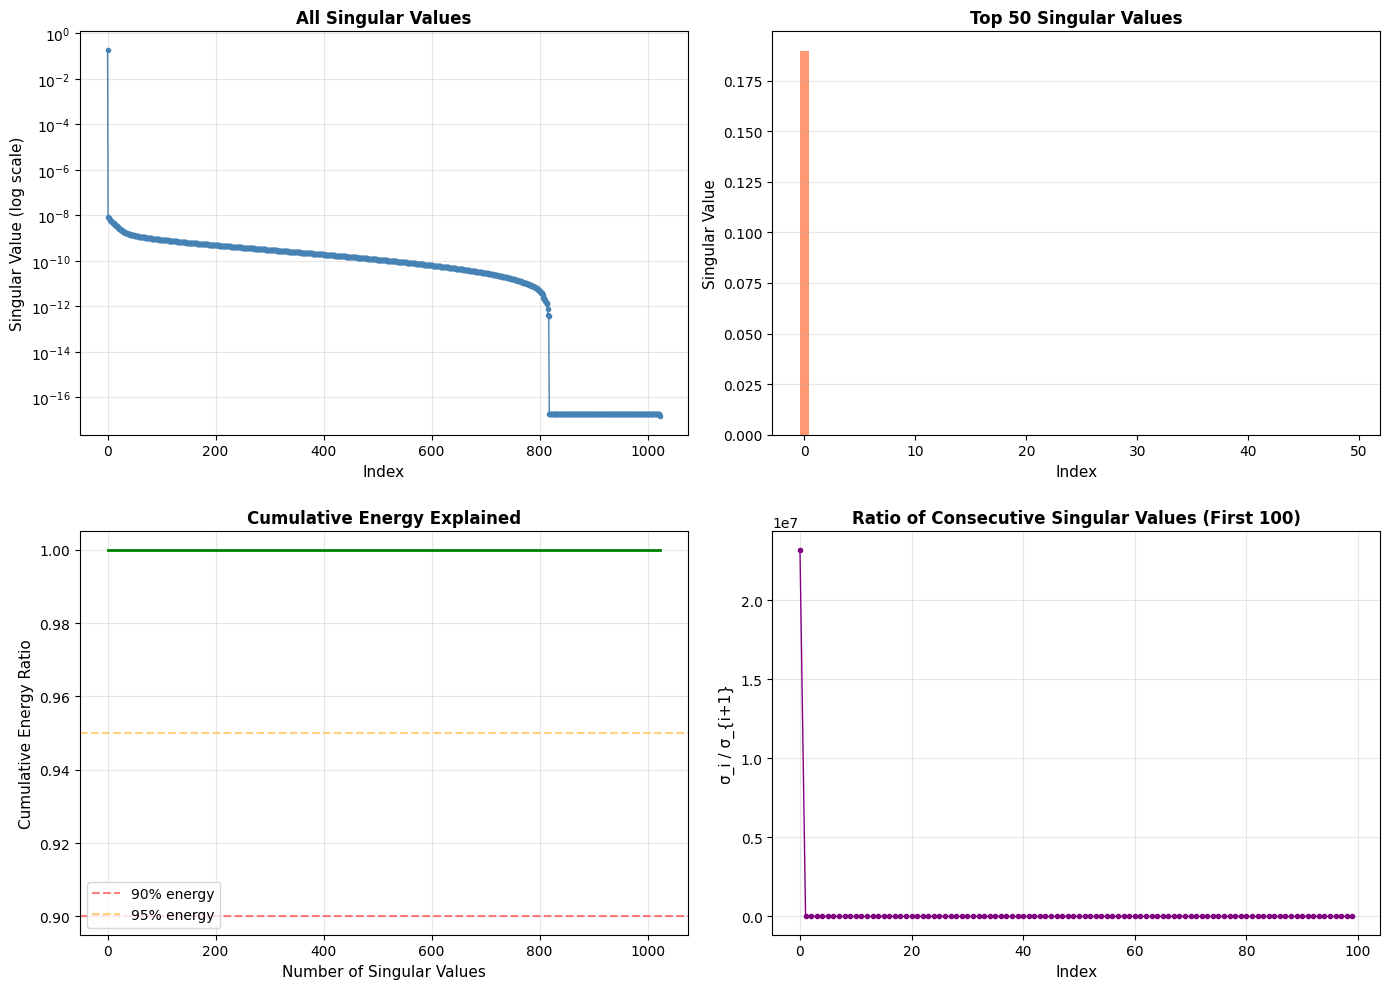


Effective rank (90% energy): 1
Effective rank (95% energy): 1


In [23]:
# Singular Value Decomposition (SVD) Analysis on the Best Operator

print(f"\n{'='*80}")
print("SINGULAR VALUE DECOMPOSITION (SVD) ANALYSIS")
print(f"{'='*80}")
print(f"Analyzing operator from best layer: {best_layer}")

# Perform SVD on the best operator's coefficient matrix
U, singular_values, Vt = np.linalg.svd(best_operator.coef_, full_matrices=False)

print(f"\nOperator coefficient matrix shape: {best_operator.coef_.shape}")
print(f"Singular values shape: {singular_values.shape}")
print(f"U matrix shape: {U.shape}")
print(f"V^T matrix shape: {Vt.shape}")

# Analyze singular values
print(f"\n{'='*60}")
print("SINGULAR VALUE STATISTICS")
print(f"{'='*60}")
print(f"Number of singular values: {len(singular_values)}")
print(f"Largest singular value: {singular_values[0]:.6e}")
print(f"Smallest singular value: {singular_values[-1]:.6e}")
print(f"Condition number: {singular_values[0] / singular_values[-1]:.6e}")

# Top 10 singular values
top_10_sv = singular_values[:10]
print(f"\nTop 10 singular values:")
for i, sv in enumerate(top_10_sv, 1):
    print(f"  σ_{i}: {sv:.6e}")

# Calculate cumulative explained variance
total_energy = np.sum(singular_values**2)
cumulative_energy = np.cumsum(singular_values**2) / total_energy

print(f"\nCumulative energy (variance) explained:")
print(f"  Top 1 singular value: {cumulative_energy[0]*100:.2f}%")
print(f"  Top 5 singular values: {cumulative_energy[4]*100:.2f}%")
print(f"  Top 10 singular values: {cumulative_energy[9]*100:.2f}%")
print(f"  Top 50 singular values: {cumulative_energy[49]*100:.2f}%")
print(f"  Top 100 singular values: {cumulative_energy[99]*100:.2f}%")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Singular values (log scale)
ax1 = axes[0, 0]
ax1.plot(singular_values, 'o-', color='steelblue', markersize=3, linewidth=1)
ax1.set_yscale('log')
ax1.set_xlabel('Index', fontsize=11)
ax1.set_ylabel('Singular Value (log scale)', fontsize=11)
ax1.set_title('All Singular Values', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3)

# Plot 2: Top 50 singular values
ax2 = axes[0, 1]
ax2.bar(range(50), singular_values[:50], color='coral', alpha=0.8)
ax2.set_xlabel('Index', fontsize=11)
ax2.set_ylabel('Singular Value', fontsize=11)
ax2.set_title('Top 50 Singular Values', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

# Plot 3: Cumulative energy
ax3 = axes[1, 0]
ax3.plot(cumulative_energy, linewidth=2, color='green')
ax3.axhline(y=0.9, color='red', linestyle='--', alpha=0.5, label='90% energy')
ax3.axhline(y=0.95, color='orange', linestyle='--', alpha=0.5, label='95% energy')
ax3.set_xlabel('Number of Singular Values', fontsize=11)
ax3.set_ylabel('Cumulative Energy Ratio', fontsize=11)
ax3.set_title('Cumulative Energy Explained', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(alpha=0.3)

# Plot 4: Ratio of consecutive singular values
ax4 = axes[1, 1]
sv_ratios = singular_values[:-1] / singular_values[1:]
ax4.plot(sv_ratios[:100], 'o-', color='purple', markersize=3, linewidth=1)
ax4.set_xlabel('Index', fontsize=11)
ax4.set_ylabel('σ_i / σ_{i+1}', fontsize=11)
ax4.set_title('Ratio of Consecutive Singular Values (First 100)', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Determine effective rank (90% energy threshold)
energy_threshold = 0.90
effective_rank = np.argmax(cumulative_energy >= energy_threshold) + 1
print(f"\nEffective rank (90% energy): {effective_rank}")

# Determine effective rank (95% energy threshold)
energy_threshold_95 = 0.95
effective_rank_95 = np.argmax(cumulative_energy >= energy_threshold_95) + 1
print(f"Effective rank (95% energy): {effective_rank_95}")

In [ ]:
import numpy as np

# Create a dictionary to store all operators and their parameters
model_two = {
    'operators': {},  # Will store operator parameters
    'faithfulness_scores': faithfulness_scores.copy(),
    'best_layer': best_layer,
    'best_faithfulness': best_faithfulness,
    'best_operator_params': {
        'coef': best_operator.coef_.tolist(),
        'intercept': best_operator.intercept_.tolist()
    },
    'averaged_operator_params': {
        'coef': averaged_operator.coef_.tolist(),
        'intercept': averaged_operator.intercept_.tolist()
    },
    'train_data': train_data,
    'test_data': test_data,
    'metadata': {
        'model_name': MODEL_NAME,
        'template': TEMPLATE,
        'data_file': DATA_FILE,
        'train_size': len(train_data),
        'test_size': len(test_data),
        'layers_tested': list(results.keys())
    }
}

# Store parameters for each layer's operator
for layer_name, operator in results.items():
    model_one['operators'][layer_name] = {
        'coef': operator.coef_.tolist(),
        'intercept': operator.intercept_.tolist()
    }

# Save to JSON file
json_filename = f"model_two_{MODEL_NAME.replace('/', '_')}_{data_file_dropdown.value.replace('/', '_').replace('.json', '')}.json"
with open(json_filename, 'w') as f:
    json.dump(model_one, f, indent=2)

print(f"Saved model_one to {json_filename}")
print(f"\nmodel_one contains:")
print(f"  - {len(model_one['operators'])} layer-specific operators (as parameters)")
print(f"  - Faithfulness scores for each layer")
print(f"  - Best operator from layer {best_layer} (as parameters)")
print(f"  - Averaged operator from Leave-One-Out CV (as parameters)")
print(f"  - Training data: {len(model_one['train_data'])} samples")
print(f"  - Test data: {len(model_one['test_data'])} samples")

# To reload operators later, you can reconstruct them like this:
# reconstructed_operator = LinearRegression()
# reconstructed_operator.coef_ = np.array(model_one['best_operator_params']['coef'])
# reconstructed_operator.intercept_ = np.array(model_one['best_operator_params']['intercept'])


NameError: name 'averaged_operator' is not defined

In [ ]:
# Use all training examples for few-shot learning
k_fold_samples = train_data.copy()

print(f"K-Fold Few-Shot Learning with {K_FOLD_SIZE} samples")
print(f"Using Layer: {BEST_LAYER}")
print(f"\nSamples: {k_fold_samples}\n")

# Leave-One-Out Cross Validation
loo = LeaveOneOut()
operators_list = []
bias_list = []

for fold_idx, (train_idx, test_idx) in enumerate(loo.split(k_fold_samples)):
    print(f"\n{'='*60}")
    print(f"Fold {fold_idx + 1}/{K_FOLD_SIZE}")
    print(f"{'='*60}")
    
    # Split data for this fold
    fold_train = [k_fold_samples[i] for i in train_idx]
    fold_test = [k_fold_samples[i] for i in test_idx]
    
    # Create few-shot template by prepending training examples
    few_shot_examples = "\n".join([
        TEMPLATE.format(sample['subject']) + f" {sample['object']}."
        for sample in fold_train
    ])
    few_shot_template = few_shot_examples + "\n" + TEMPLATE
    
    print(f"Few-shot template:\n{few_shot_template}\n")
    print(f"Test sample: {fold_test[0]}")
    
    # Train operator on this fold
    operator = lre.train_lre(fold_train, BEST_LAYER, few_shot_template)
    
    # Store operator weights and bias
    operators_list.append(operator.coef_)
    bias_list.append(operator.intercept_)
    
    # Evaluate on the left-out sample
    lre.evaluate(operator, fold_test, BEST_LAYER, few_shot_template)

# Average the operators
print(f"\n{'='*60}")
print("AVERAGING OPERATORS")
print(f"{'='*60}")

avg_coef = np.mean(operators_list, axis=0)
avg_bias = np.mean(bias_list, axis=0)

# Create averaged operator
averaged_operator = LinearRegression()
averaged_operator.coef_ = avg_coef
averaged_operator.intercept_ = avg_bias

print(f"\nAveraged operator created from {K_FOLD_SIZE} folds")
print(f"Coefficient shape: {avg_coef.shape}")
print(f"Bias shape: {avg_bias.shape}")

# Create few-shot template with ALL training samples for consistent evaluation
few_shot_examples_all = "\n".join([
    TEMPLATE.format(sample['subject']) + f" {sample['object']}."
    for sample in k_fold_samples
])
few_shot_template_all = few_shot_examples_all + "\n" + TEMPLATE

# Evaluate averaged operator on all k_fold_samples WITH FEW-SHOT TEMPLATE
print(f"\nEvaluating averaged operator on all {K_FOLD_SIZE} samples:")
lre.evaluate(averaged_operator, k_fold_samples, BEST_LAYER, few_shot_template_all)

In [ ]:
import copy

# Prompt Perturbation Experiment

# Define prompt variations
prompt_variations = [
    "{} is commonly associated with",
    "{} is typically associated with",
    "{} is often associated with",
    "{} is usually associated with",
    "{} is generally associated with"
]

print(f"\n{'='*80}")
print("PROMPT PERTURBATION EXPERIMENT")
print(f"{'='*80}")
print(f"Training with {len(prompt_variations)} prompt variations")
print(f"Using best layer: {best_layer}")

# Store operators trained with different prompts
perturbed_operators = {}
perturbed_scores = {}

for i, prompt_template in enumerate(prompt_variations):
    print(f"\n{'='*60}")
    print(f"Variation {i+1}/{len(prompt_variations)}: '{prompt_template}'")
    print(f"{'='*60}")
    
    # Train with Leave-One-Out Cross Validation using this prompt variation
    loo_perturb = LeaveOneOut()
    perturb_operators_list = []
    perturb_bias_list = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(loo_perturb.split(train_data)):
        fold_train = [train_data[i] for i in train_idx]
        
        # Create few-shot template with perturbed prompt
        few_shot_examples = "\n".join([
            prompt_template.format(sample['subject']) + f" {sample['object']}."
            for sample in fold_train
        ])
        few_shot_template_perturb = few_shot_examples + "\n" + prompt_template
        
        # Train operator on this fold with perturbed prompt
        operator_fold = lre.train_lre(fold_train, best_layer, few_shot_template_perturb)
        
        # Store operator weights and bias
        perturb_operators_list.append(operator_fold.coef_)
        perturb_bias_list.append(operator_fold.intercept_)
    
    # Average the operators for this prompt variation
    avg_coef_perturb = np.mean(perturb_operators_list, axis=0)
    avg_bias_perturb = np.mean(perturb_bias_list, axis=0)
    
    # Create averaged operator
    averaged_operator_perturb = LinearRegression()
    averaged_operator_perturb.coef_ = avg_coef_perturb
    averaged_operator_perturb.intercept_ = avg_bias_perturb
    
    # Create few-shot template with all training examples using same prompt variation
    few_shot_examples_full = "\n".join([
        prompt_template.format(sample['subject']) + f" {sample['object']}."
        for sample in train_data
    ])
    few_shot_template_full_perturb = few_shot_examples_full + "\n" + prompt_template
    
    # Evaluate on test_data with the same perturbed prompt
    print(f"\nEvaluating with same prompt variation on test set:")
    eval_results_perturb = lre.evaluate(
        averaged_operator_perturb, 
        test_data, 
        best_layer, 
        few_shot_template_full_perturb
    )
    
    # Store results
    perturbed_operators[prompt_template] = averaged_operator_perturb
    perturbed_scores[prompt_template] = eval_results_perturb.get('faithfulness', 0)

# Summary of perturbation experiment
print(f"\n{'='*80}")
print("PROMPT PERTURBATION SUMMARY")
print(f"{'='*80}")
for prompt_template in prompt_variations:
    print(f"'{prompt_template}': Faithfulness = {perturbed_scores[prompt_template]:.4f}")

# Find best performing prompt variation
best_prompt = max(perturbed_scores, key=perturbed_scores.get)
best_prompt_score = perturbed_scores[best_prompt]
print(f"\nBest prompt variation: '{best_prompt}'")
print(f"Best faithfulness score: {best_prompt_score:.4f}")

# Cross-evaluation: Test each operator with different prompts at inference
print(f"\n{'='*80}")
print("CROSS-EVALUATION: Training vs Inference Prompt Mismatch")
print(f"{'='*80}")

cross_eval_results = {}
for train_prompt in prompt_variations:
    cross_eval_results[train_prompt] = {}
    operator = perturbed_operators[train_prompt]
    
    for test_prompt in prompt_variations:
        # Create few-shot template with test prompt
        few_shot_examples_test = "\n".join([
            test_prompt.format(sample['subject']) + f" {sample['object']}."
            for sample in train_data
        ])
        few_shot_template_test = few_shot_examples_test + "\n" + test_prompt
        
        # Evaluate
        eval_results = lre.evaluate(
            operator, 
            test_data, 
            best_layer, 
            few_shot_template_test
        )
        cross_eval_results[train_prompt][test_prompt] = eval_results.get('faithfulness', 0)

# Display cross-evaluation matrix
print("\nCross-Evaluation Matrix (Faithfulness Scores):")
print(f"{'Train Prompt':<40} | {'Test Prompts'}")
print("-" * 120)
for i, train_prompt in enumerate(prompt_variations):
    scores = [f"{cross_eval_results[train_prompt][test_prompt]:.3f}" 
              for test_prompt in prompt_variations]
    print(f"{i+1}. {train_prompt:<35} | {' | '.join(scores)}")


PROMPT PERTURBATION EXPERIMENT
Training with 5 prompt variations
Using best layer: model.layers.8

Variation 1/5: '{} is commonly associated with'
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations.

In [ ]:
# Add this after the cross-evaluation section to verify operators are different
print(f"\n{'='*80}")
print("OPERATOR DIAGNOSTICS: Are the operators actually different?")
print(f"{'='*80}")

# Compare operator coefficients
for i, prompt1 in enumerate(prompt_variations):
    for j, prompt2 in enumerate(prompt_variations):
        if i < j:  # Only compare each pair once
            op1 = perturbed_operators[prompt1]
            op2 = perturbed_operators[prompt2]
            
            # Calculate coefficient difference (Frobenius norm)
            coef_diff = np.linalg.norm(op1.coef_ - op2.coef_)
            bias_diff = np.abs(op1.intercept_ - op2.intercept_).mean()
            
            print(f"\nPrompt {i+1} vs Prompt {j+1}:")
            print(f"  Coefficient difference: {coef_diff:.6f}")
            print(f"  Bias difference: {bias_diff:.6f}")



OPERATOR DIAGNOSTICS: Are the operators actually different?

Prompt 1 vs Prompt 2:
  Coefficient difference: 0.007879
  Bias difference: 0.022832

Prompt 1 vs Prompt 3:
  Coefficient difference: 0.006482
  Bias difference: 0.056147

Prompt 1 vs Prompt 4:
  Coefficient difference: 0.010313
  Bias difference: 0.116447

Prompt 1 vs Prompt 5:
  Coefficient difference: 0.007170
  Bias difference: 0.094889

Prompt 2 vs Prompt 3:
  Coefficient difference: 0.008472
  Bias difference: 0.033314

Prompt 2 vs Prompt 4:
  Coefficient difference: 0.007822
  Bias difference: 0.093615

Prompt 2 vs Prompt 5:
  Coefficient difference: 0.005663
  Bias difference: 0.072057

Prompt 3 vs Prompt 4:
  Coefficient difference: 0.008141
  Bias difference: 0.060301

Prompt 3 vs Prompt 5:
  Coefficient difference: 0.006566
  Bias difference: 0.038743

Prompt 4 vs Prompt 5:
  Coefficient difference: 0.007095
  Bias difference: 0.021558


In [ ]:
# Add this after the prompt perturbation experiment completes

print(f"\n{'='*80}")
print("OPERATOR DIFFERENCE ANALYSIS")
print(f"{'='*80}")

# Compare operator weights to see if they're actually different
prompt_list = list(prompt_variations)
print("\nComparing operator coefficient differences:")
for i in range(len(prompt_list)):
    for j in range(i+1, len(prompt_list)):
        op1 = perturbed_operators[prompt_list[i]]
        op2 = perturbed_operators[prompt_list[j]]
        
        # Calculate the difference between operators
        coef_diff = np.abs(op1.coef_ - op2.coef_).mean()
        bias_diff = np.abs(op1.intercept_ - op2.intercept_).mean()
        
        print(f"\n'{prompt_list[i]}' vs '{prompt_list[j]}':")
        print(f"  Mean absolute coefficient difference: {coef_diff:.2e}")
        print(f"  Mean absolute bias difference: {bias_diff:.2e}")

# Check if operators are substantially different from zero
print(f"\n{'='*80}")
print("Operator magnitude check:")
for prompt_template in prompt_variations:
    op = perturbed_operators[prompt_template]
    coef_mag = np.abs(op.coef_).mean()
    bias_mag = np.abs(op.intercept_).mean()
    print(f"\n'{prompt_template}':")
    print(f"  Mean |coefficient|: {coef_mag:.2e}")
    print(f"  Mean |bias|: {bias_mag:.2e}")



OPERATOR DIFFERENCE ANALYSIS

Comparing operator coefficient differences:

'{} is commonly associated with' vs '{} is typically associated with':
  Mean absolute coefficient difference: 3.98e-06
  Mean absolute bias difference: 2.28e-02

'{} is commonly associated with' vs '{} is often associated with':
  Mean absolute coefficient difference: 3.24e-06
  Mean absolute bias difference: 5.61e-02

'{} is commonly associated with' vs '{} is usually associated with':
  Mean absolute coefficient difference: 5.16e-06
  Mean absolute bias difference: 1.16e-01

'{} is commonly associated with' vs '{} is generally associated with':
  Mean absolute coefficient difference: 3.66e-06
  Mean absolute bias difference: 9.49e-02

'{} is typically associated with' vs '{} is often associated with':
  Mean absolute coefficient difference: 4.27e-06
  Mean absolute bias difference: 3.33e-02

'{} is typically associated with' vs '{} is usually associated with':
  Mean absolute coefficient difference: 3.83e-06

In [ ]:
# Robustness Test: Prepending text to the prompt template

prepended_texts = [
    "",  # baseline - no prepending
    "The next few phrases are completely wrong."
]

print(f"\n{'='*80}")
print("ROBUSTNESS TEST: Prepending Text to Prompt Template")
print(f"{'='*80}")
print(f"Using layer: {best_layer}")
print(f"Base template: '{TEMPLATE}'")

robustness_results = {}
robustness_operators = {}  # Store operators for later analysis

for prepend_text in prepended_texts:
    print(f"\n{'='*60}")
    print(f"Testing with prepended text: '{prepend_text}'")
    print(f"{'='*60}")
    
    # Train with Leave-One-Out Cross Validation using prepended text
    loo_robust = LeaveOneOut()
    robust_operators_list = []
    robust_bias_list = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(loo_robust.split(train_data)):
        fold_train = [train_data[i] for i in train_idx]
        
        # Create few-shot template with prepended text
        few_shot_examples = "\n".join([
            TEMPLATE.format(sample['subject']) + f" {sample['object']}."
            for sample in fold_train
        ])
        
        if prepend_text:
            few_shot_template_robust = prepend_text + "\n" + few_shot_examples + "\n" + TEMPLATE
        else:
            few_shot_template_robust = few_shot_examples + "\n" + TEMPLATE
        
        # Train operator on this fold with prepended text
        operator_fold = lre.train_lre(fold_train, best_layer, few_shot_template_robust)
        
        # Store operator weights and bias
        robust_operators_list.append(operator_fold.coef_)
        robust_bias_list.append(operator_fold.intercept_)
    
    # Average the operators for this prepended text
    avg_coef_robust = np.mean(robust_operators_list, axis=0)
    avg_bias_robust = np.mean(robust_bias_list, axis=0)
    
    # Create averaged operator
    averaged_operator_robust = LinearRegression()
    averaged_operator_robust.coef_ = avg_coef_robust
    averaged_operator_robust.intercept_ = avg_bias_robust
    
    # Store the operator
    robustness_operators[prepend_text] = averaged_operator_robust
    
    # Create few-shot template with all training examples and prepended text for evaluation
    few_shot_examples_full = "\n".join([
        TEMPLATE.format(sample['subject']) + f" {sample['object']}."
        for sample in train_data
    ])
    
    if prepend_text:
        few_shot_template_full_robust = prepend_text + "\n" + few_shot_examples_full + "\n" + TEMPLATE
    else:
        few_shot_template_full_robust = few_shot_examples_full + "\n" + TEMPLATE
    
    print(f"Modified template structure:")
    print(f"{few_shot_template_full_robust[:200]}...")
    
    # Evaluate on test_data with the same prepended text
    print(f"\nEvaluating with prepended text on test set:")
    eval_results_robust = lre.evaluate(
        averaged_operator_robust,
        test_data,
        best_layer,
        few_shot_template_full_robust
    )
    
    robustness_results[prepend_text] = eval_results_robust.get('faithfulness', 0)

# Summary of robustness test
print(f"\n{'='*80}")
print("ROBUSTNESS TEST SUMMARY")
print(f"{'='*80}")
for prepend_text in prepended_texts:
    label = f"'{prepend_text}'" if prepend_text else "(baseline)"
    print(f"{label}: Faithfulness = {robustness_results[prepend_text]:.4f}")

# Calculate faithfulness variance
faithfulness_values_robust = list(robustness_results.values())
faithfulness_variance = np.var(faithfulness_values_robust)
faithfulness_std = np.std(faithfulness_values_robust)

print(f"\nFaithfulness variance: {faithfulness_variance:.6f}")
print(f"Faithfulness std dev: {faithfulness_std:.6f}")

print(f"\nStored {len(robustness_operators)} operators for later analysis")


ROBUSTNESS TEST: Prepending Text to Prompt Template
Using layer: model.layers.8
Base template: '{} is commonly associated with'

Testing with prepended text: ''
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training re

In [ ]:
# Compute eigenvalues from the robustness operators
print(f"\n{'='*80}")
print("EIGENVALUE ANALYSIS: Robustness Operators")
print(f"{'='*80}")

# Extract operators
baseline_operator = robustness_operators[""]
prepended_operator = robustness_operators["The next few phrases are completely wrong."]

# Compute eigenvalues for baseline operator
baseline_eigenvalues = np.linalg.eigvals(baseline_operator.coef_)
baseline_eigenvalues_sorted = np.sort(np.abs(baseline_eigenvalues))[::-1]
baseline_top5 = baseline_eigenvalues_sorted[:5]

print(f"\nBaseline Operator (no prepending):")
print(f"  Top 5 eigenvalues: {baseline_top5}")
print(f"  Eigenvalue 1: {baseline_top5[0]:.6e}")

# Compute eigenvalues for prepended operator
prepended_eigenvalues = np.linalg.eigvals(prepended_operator.coef_)
prepended_eigenvalues_sorted = np.sort(np.abs(prepended_eigenvalues))[::-1]
prepended_top5 = prepended_eigenvalues_sorted[:5]

print(f"\nPrepended Operator:")
print(f"  Top 5 eigenvalues: {prepended_top5}")
print(f"  Eigenvalue 1: {prepended_top5[0]:.6e}")

# Calculate similarity
eigenvalue_diff = np.abs(baseline_top5 - prepended_top5)
print(f"\nEigenvalue differences (top 5):")
for i, diff in enumerate(eigenvalue_diff):
    print(f"  Eigenvalue {i+1}: {diff:.6e}")


EIGENVALUE ANALYSIS: Robustness Operators

Baseline Operator (no prepending):
  Top 5 eigenvalues: [1.3166091e-03 8.1576086e-11 8.0535620e-11 8.0535620e-11 7.9504424e-11]
  Eigenvalue 1: 1.316609e-03

Prepended Operator:
  Top 5 eigenvalues: [1.3193586e-03 8.2451594e-11 8.2451594e-11 8.0907690e-11 8.0907690e-11]
  Eigenvalue 1: 1.319359e-03

Eigenvalue differences (top 5):
  Eigenvalue 1: 2.749497e-06
  Eigenvalue 2: 8.755080e-13
  Eigenvalue 3: 1.915974e-12
  Eigenvalue 4: 3.720704e-13
  Eigenvalue 5: 1.403266e-12


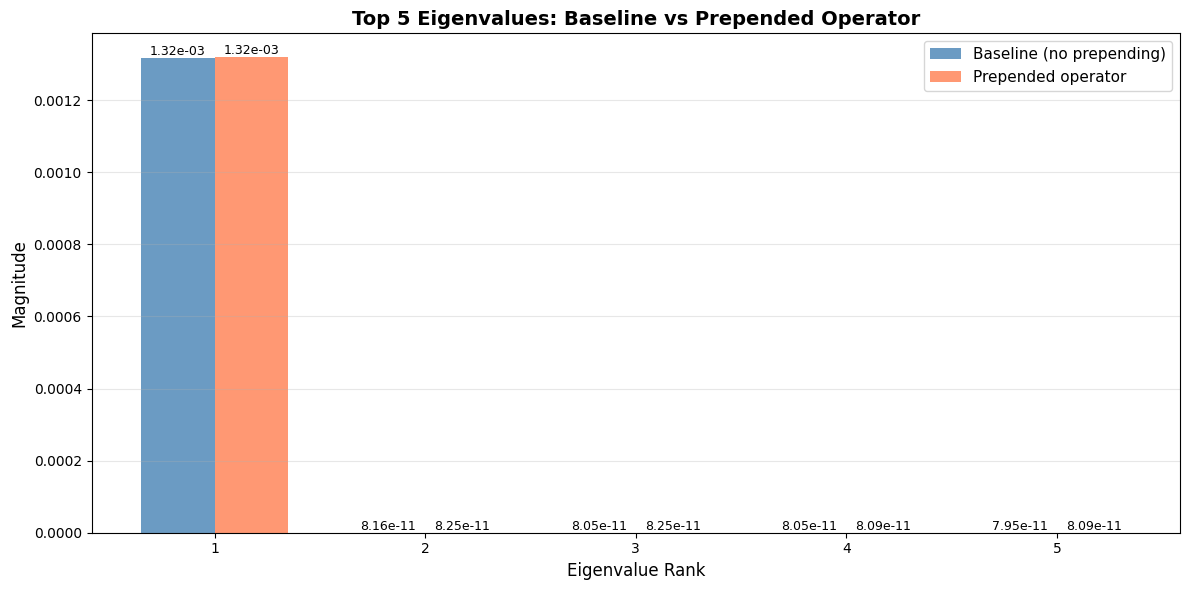


Top 5 Eigenvalues Comparison:
Rank   Baseline        Prepended       Diff           
-------------------------------------------------------
1      1.316609e-03    1.319359e-03    2.749497e-06   
2      8.157609e-11    8.245159e-11    8.755080e-13   
3      8.053562e-11    8.245159e-11    1.915974e-12   
4      8.053562e-11    8.090769e-11    3.720704e-13   
5      7.950442e-11    8.090769e-11    1.403266e-12   


In [ ]:
# Plot comparing top 5 eigenvalues
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(5)
width = 0.35

bars1 = ax.bar(x - width/2, baseline_top5, width, label='Baseline (no prepending)', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, prepended_top5, width, label='Prepended operator', alpha=0.8, color='coral')

ax.set_xlabel('Eigenvalue Rank', fontsize=12)
ax.set_ylabel('Magnitude', fontsize=12)
ax.set_title('Top 5 Eigenvalues: Baseline vs Prepended Operator', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'{i+1}' for i in range(5)])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2e}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print comparison statistics
print(f"\nTop 5 Eigenvalues Comparison:")
print(f"{'Rank':<6} {'Baseline':<15} {'Prepended':<15} {'Diff':<15}")
print("-" * 55)
for i in range(5):
    diff = abs(baseline_top5[i] - prepended_top5[i])
    print(f"{i+1:<6} {baseline_top5[i]:<15.6e} {prepended_top5[i]:<15.6e} {diff:<15.6e}")


In [ ]:
import copy

# Prompt Perturbation Experiment

# Define prompt variations
prompt_variations = [
    "{} is commonly associated with",
    "{} is typically associated with",
    "{} is often associated with",
    "{} is usually associated with",
    "{} is generally associated with"
]

print(f"\n{'='*80}")
print("PROMPT PERTURBATION EXPERIMENT")
print(f"{'='*80}")
print(f"Training with {len(prompt_variations)} prompt variations")
print(f"Using best layer: {best_layer}")

# Store operators trained with different prompts
perturbed_operators = {}
perturbed_scores = {}

for i, prompt_template in enumerate(prompt_variations):
    print(f"\n{'='*60}")
    print(f"Variation {i+1}/{len(prompt_variations)}: '{prompt_template}'")
    print(f"{'='*60}")
    
    # Train with Leave-One-Out Cross Validation using this prompt variation
    loo_perturb = LeaveOneOut()
    perturb_operators_list = []
    perturb_bias_list = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(loo_perturb.split(train_data)):
        fold_train = [train_data[i] for i in train_idx]
        
        # Create few-shot template with perturbed prompt
        few_shot_examples = "\n".join([
            prompt_template.format(sample['subject']) + f" {sample['object']}."
            for sample in fold_train
        ])
        few_shot_template_perturb = few_shot_examples + "\n" + prompt_template
        
        # Train operator on this fold with perturbed prompt
        operator_fold = lre.train_lre(fold_train, best_layer, few_shot_template_perturb)
        
        # Store operator weights and bias
        perturb_operators_list.append(operator_fold.coef_)
        perturb_bias_list.append(operator_fold.intercept_)
    
    # Average the operators for this prompt variation
    avg_coef_perturb = np.mean(perturb_operators_list, axis=0)
    avg_bias_perturb = np.mean(perturb_bias_list, axis=0)
    
    # Create averaged operator
    averaged_operator_perturb = LinearRegression()
    averaged_operator_perturb.coef_ = avg_coef_perturb
    averaged_operator_perturb.intercept_ = avg_bias_perturb
    
    # Create few-shot template with all training examples using same prompt variation
    few_shot_examples_full = "\n".join([
        prompt_template.format(sample['subject']) + f" {sample['object']}."
        for sample in train_data
    ])
    few_shot_template_full_perturb = few_shot_examples_full + "\n" + prompt_template
    
    # Evaluate on test_data with the same perturbed prompt
    print(f"\nEvaluating with same prompt variation on test set:")
    eval_results_perturb = lre.evaluate(
        averaged_operator_perturb, 
        test_data, 
        best_layer, 
        few_shot_template_full_perturb
    )
    
    # Store results
    perturbed_operators[prompt_template] = averaged_operator_perturb
    perturbed_scores[prompt_template] = eval_results_perturb.get('faithfulness', 0)

# Summary of perturbation experiment
print(f"\n{'='*80}")
print("PROMPT PERTURBATION SUMMARY")
print(f"{'='*80}")
for prompt_template in prompt_variations:
    print(f"'{prompt_template}': Faithfulness = {perturbed_scores[prompt_template]:.4f}")

# Find best performing prompt variation
best_prompt = max(perturbed_scores, key=perturbed_scores.get)
best_prompt_score = perturbed_scores[best_prompt]
print(f"\nBest prompt variation: '{best_prompt}'")
print(f"Best faithfulness score: {best_prompt_score:.4f}")

# Cross-evaluation: Test each operator with different prompts at inference
print(f"\n{'='*80}")
print("CROSS-EVALUATION: Training vs Inference Prompt Mismatch")
print(f"{'='*80}")

cross_eval_results = {}
for train_prompt in prompt_variations:
    cross_eval_results[train_prompt] = {}
    operator = perturbed_operators[train_prompt]
    
    for test_prompt in prompt_variations:
        # Create few-shot template with test prompt
        few_shot_examples_test = "\n".join([
            test_prompt.format(sample['subject']) + f" {sample['object']}."
            for sample in train_data
        ])
        few_shot_template_test = few_shot_examples_test + "\n" + test_prompt
        
        # Evaluate
        eval_results = lre.evaluate(
            operator, 
            test_data, 
            best_layer, 
            few_shot_template_test
        )
        cross_eval_results[train_prompt][test_prompt] = eval_results.get('faithfulness', 0)

# Display cross-evaluation matrix
print("\nCross-Evaluation Matrix (Faithfulness Scores):")
print(f"{'Train Prompt':<40} | {'Test Prompts'}")
print("-" * 120)
for i, train_prompt in enumerate(prompt_variations):
    scores = [f"{cross_eval_results[train_prompt][test_prompt]:.3f}" 
              for test_prompt in prompt_variations]
    print(f"{i+1}. {train_prompt:<35} | {' | '.join(scores)}")


PROMPT PERTURBATION EXPERIMENT
Training with 5 prompt variations
Using best layer: model.layers.8

Variation 1/5: '{} is commonly associated with'
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations.


PROMPT PERTURBATION EXPERIMENT
Training with 5 prompt variations
Using best layer: model.layers.8

Variation 1/5: '{} is commonly associated with'
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations.

KeyboardInterrupt: 

## 5. Additional Experiment: Different Prompt Template

Let's also test whether a different prompt format affects results.


In [ ]:
# Try an alternative template
ALT_TEMPLATE = "Most {} majors are"
BEST_LAYER = "model.layers.15"  # Based on results above, adjust if needed

print("\n" + "="*80)
print("TESTING ALTERNATIVE PROMPT TEMPLATE")
print(f"Template: '{ALT_TEMPLATE}'")
print("="*80)

operator_alt = lre.train_lre(train_data, BEST_LAYER, ALT_TEMPLATE)
lre.evaluate(operator_alt, test_data, BEST_LAYER, ALT_TEMPLATE)


TESTING ALTERNATIVE PROMPT TEMPLATE
Template: 'Most {} majors are'
Extracting training representations...
Solving Linear Regression...

                               EVALUATION RESULTS                               
Subject                   Expected        LRE Prediction      Status
--------------------------------------------------------------------------------
risk-taking               men             women              ✗ Wrong
leadership                men             men              ✓ Correct
meticulousness            women           men                ✗ Wrong
decisiveness              men             men              ✓ Correct
patience                  women           men                ✗ Wrong
humility                  women           men                ✗ Wrong
adventurousness           men             men              ✓ Correct
independence              men             men              ✓ Correct
generosity                women           men                ✗ Wrong
empathy    

{'correct': 5, 'total': 12, 'faithfulness': 0.4166666666666667}

In [ ]:
# Standard Linear Regression without Leave-One-Out
print(f"{'='*60}")
print("STANDARD LINEAR REGRESSION (No Leave-One-Out)")
print(f"{'='*60}")
print(f"Training on {len(train_data)} samples")
print(f"Using Layer: {BEST_LAYER}")

# Train operator on all training data
operator_standard = lre.train_lre(train_data, BEST_LAYER, TEMPLATE)

# Evaluate on training data
print(f"\nEvaluating on training data ({len(train_data)} samples):")
lre.evaluate(operator_standard, train_data, BEST_LAYER, TEMPLATE)

# Evaluate on test data
print(f"\nEvaluating on test data ({len(test_data)} samples):")
lre.evaluate(operator_standard, test_data, BEST_LAYER, TEMPLATE)

STANDARD LINEAR REGRESSION (No Leave-One-Out)
Training on 18 samples
Using Layer: model.layers.15
Extracting training representations...
Solving Linear Regression...

Evaluating on training data (18 samples):

                               EVALUATION RESULTS                               
Subject                   Expected        LRE Prediction      Status
--------------------------------------------------------------------------------
multitasking              women           women            ✓ Correct
aggressiveness            men             men              ✓ Correct
flexibility               women           women            ✓ Correct
bravery                   men             men              ✓ Correct
ambition                  men             men              ✓ Correct
assertiveness             men             men              ✓ Correct
creativity                women           women            ✓ Correct
logical thinking          men             men              ✓ Correct
sensiti

{'correct': 5, 'total': 12, 'faithfulness': 0.4166666666666667}